In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
def convert_raw_data(dataframe):
    dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    dataframe['Open'] = dataframe['Open'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Price'] = dataframe['Price'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['High'] = dataframe['High'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe['Low'] = dataframe['Low'].replace({',': ''}, regex=True).apply(pd.to_numeric)
    dataframe = dataframe.sort_values(by='Date', ascending=True).reset_index(drop=True)
    return dataframe

In [3]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('HNX.csv')
df=convert_raw_data(df)
df1=df.reset_index()['Open']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
ratio = 0.7
train_size = int(ratio * len(df1))
test_size = int((1-ratio) * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
37/37 [==============================] - 4s 44ms/step - loss: 0.0012 - val_loss: 0.0109
Epoch 2/100
37/37 [==============================] - 1s 32ms/step - loss: 5.1572e-05 - val_loss: 3.6019e-04
Epoch 3/100
37/37 [==============================] - 1s 33ms/step - loss: 1.8661e-05 - val_loss: 3.0709e-04
Epoch 4/100
37/37 [==============================] - 1s 32ms/step - loss: 1.7892e-05 - val_loss: 2.9778e-04
Epoch 5/100
11/37 [=======>......................] - ETA: 0s - loss: 1.6671e-05

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

19/19 [==============================] - 0s 7ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [ ]:
mae = mean_absolute_error(ytest, y_pred)
mse = mean_squared_error(ytest, y_pred)
mape = mean_absolute_percentage_error(ytest, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

MAE: 295.1897953388544
MSE: 95183.85039857627
RMSE: 308.51880072140864
MAPE: 550.8067848766378


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1] -1
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.62979175 0.60470206 0.57706279 0.60073103 0.58818619 0.60034747
 0.60513075 0.60391237 0.59344329 0.60115972 0.60490512 0.59928702
 0.60120485 0.59831682 0.59666975 0.60375443 0.61476501 0.61632183
 0.61526139 0.62067643 0.62595609 0.62527921 0.60440875 0.60731933
 0.59870039 0.57782992 0.54610681 0.55355249 0.55551544 0.57685973
 0.58010875 0.54477561 0.5651497  0.56449539 0.57611516 0.56542046
 0.56887254 0.57618285 0.5769951  0.58746418 0.59617337 0.59635387
 0.60583019 0.60781571 0.6200898  0.62011236 0.63186751 0.64235915
 0.64059926 0.64010289 0.64603687 0.66086054 0.66002572 0.66377112
 0.66661402 0.64854132 0.64120846 0.63437197 0.64389341 0.64531486
 0.65016584 0.65582907 0.65930372 0.66090567 0.66564383 0.66753909
 0.66923129 0.67645134 0.67554884 0.67336026 0.67063018 0.67730872
 0.68276889 0.69355385 0.69596805 0.69574242 0.70582794 0.70016471
 0.6970285  0.68224995 0.68908644 0.68507028 0.69206471 0.69010176
 0.69982627 0.71289005 0.71692877 0.72155412 0.724

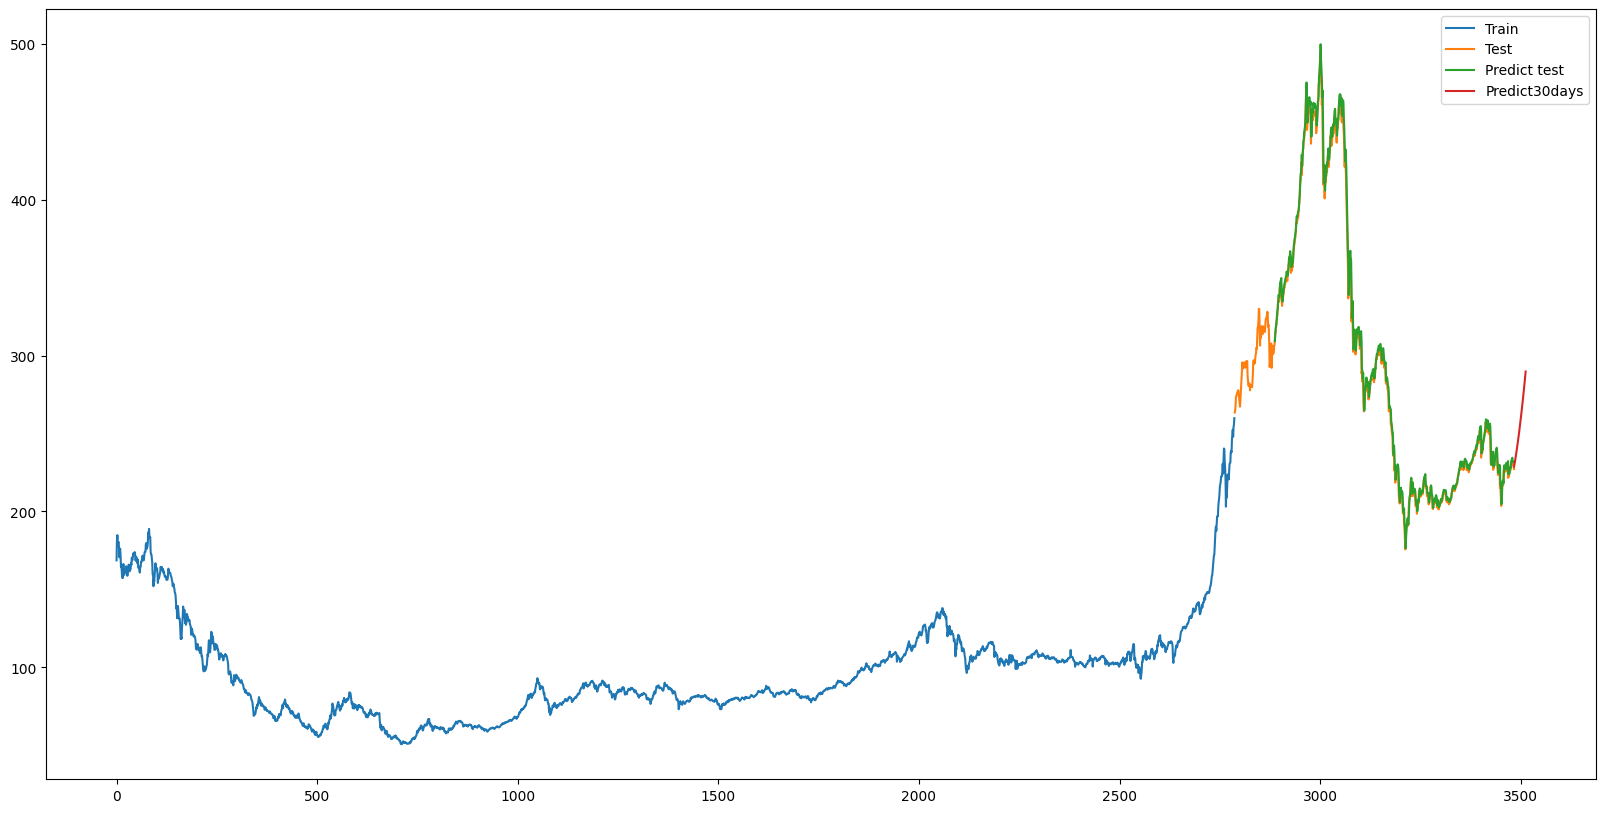

In [ ]:
# 14.Vẽ hình
plt.figure(figsize=(20, 10))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=len(df), step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+100, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict test','Predict30days'])
plt.show()

In [ ]:
scaler.inverse_transform(lst_output)

array([[228.69253588],
       [229.92457619],
       [231.39108391],
       [232.95880979],
       [234.59043931],
       [236.27506208],
       [238.00822678],
       [239.78733129],
       [241.6105396 ],
       [243.47655728],
       [245.3844597 ],
       [247.33375814],
       [249.32404315],
       [251.35519583],
       [253.42718977],
       [255.5402099 ],
       [257.69444113],
       [259.89030614],
       [262.12812194],
       [264.40850935],
       [266.73198349],
       [269.09921801],
       [271.51086014],
       [273.96774202],
       [276.47065618],
       [279.02040834],
       [281.61797595],
       [284.26431003],
       [286.96036162],
       [289.70713456]])